<center>
    <tr>
    <td><img src="ontario-tech-univ-logo.png" width="25%"></img></td>
    </tr>
</center>

# ResNet to the Rescue

Faisal Qureshi   
Professor    
Faculty of Science    
Ontario Tech University    
Oshawa ON Canada    
http://vclab.science.ontariotechu.ca

## Copyright information

&copy; Faisal Qureshi

## License

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

## Tasks

The goal of this work is to use a pre-trained ResNet model to perform "custom computer vision tasks."

Specifically, we will use a ResNet pretrained on ImageNet to perform classification on CIFAR10 dataset.  Recall that the ImageNet model has 1000 classes; where as, the CIFAR10 has only 10 classes.  This means that we cannot use ResNet model out of the box.  We will replace the classification head in the pretrained model.  We will also have to then retrain the classification head.

1. Download a pretrained ResNet model from `timm`
2. Replace the *classifier head*, i.e., the "fc" layer with our own.
3. Setup PyTorch Lightning to train the model.  We will only train the "fc" layer.

<p style="color: red;">
Go to the end of this notebook to see what you need to submit.
</p>

## Get a pretrained ResNet model

Install `timm`.  Check [https://timm.fast.ai/](https://timm.fast.ai/) for information about `timm`: a deep learning library that contains SOTA computer vision models.

In [1]:
!pip install --quiet timm
!pip install --quiet jupyterlab-widgets
!pip install --quiet ipywidgets

In [2]:
import timm
import torch

### Models available in `timm`

`timm` stands for Pytorch Image Models and it contains tons of computer vision deep learning models

In [3]:
# set the following to true to find
# the list of pretrained models only
pretrained = True

avail_models = timm.list_models(pretrained=pretrained)
len(avail_models), avail_models[:10]

(1599,
 ['aimv2_1b_patch14_224.apple_pt',
  'aimv2_1b_patch14_336.apple_pt',
  'aimv2_1b_patch14_448.apple_pt',
  'aimv2_3b_patch14_224.apple_pt',
  'aimv2_3b_patch14_336.apple_pt',
  'aimv2_3b_patch14_448.apple_pt',
  'aimv2_huge_patch14_224.apple_pt',
  'aimv2_huge_patch14_336.apple_pt',
  'aimv2_huge_patch14_448.apple_pt',
  'aimv2_large_patch14_224.apple_pt'])

### Searching models

You can also search models as follows

In [4]:
timm.list_models('resnet*', pretrained=pretrained)[:10]

['resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k']

### Getting pretrained ResNet

In [5]:
resnet = timm.create_model('resnet34', pretrained=True)

In [6]:
print('Model information:')

# Uncomment the following to print out the model.
# Recall that it is simply a PyTorch model.
#resnet

# Or better acces the config as follows
resnet.default_cfg

Model information:


{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet34_a1_0-46f8f793.pth',
 'hf_hub_id': 'timm/resnet34.a1_in1k',
 'architecture': 'resnet34',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

### Using ResNet for our task

This model was trained on ImageNet, which as 1000 classes.

In [7]:
resnet.get_classifier()

Linear(in_features=512, out_features=1000, bias=True)

#### Swapping out the classifier

We want to use this model for the task of classifying Cifar images.  Cifar has 10 classes only.  This suggests that we cannot use this model out of the box.  

We will replace the classification head (the fully-connected classifier layer with 1000 outputs).

In [8]:
resnet_cifar = timm.create_model('resnet34', pretrained=True, num_classes=10)
resnet_cifar.get_classifier()

Linear(in_features=512, out_features=10, bias=True)

Let's inspect the model

In [9]:
resnet_cifar

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [10]:
import types
import torch.nn as nn

def get_classifier(self):
    if isinstance(self.fc, nn.Linear):
        return self.fc
    elif isinstance(self.fc, nn.Sequential):
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                return layer
        raise ValueError("No Linear layer found in model.fc.")
    else:
        raise TypeError("Unsupported classifier structure.")

# Patch the method onto the model instance
resnet_cifar.get_classifier = types.MethodType(get_classifier, resnet_cifar)

## Training the classifier

Since we have replaced the classification head in the pretrained model with our own classification layer, we need to train the classification head. 

### PyTorch Lightning: A Framework for Model Training

Check out [lightning.ai](lightning.ai).

In [11]:
!pip install --quiet lightning
!pip install --quiet seaborn
!pip install --quiet tabulate

In [12]:
import lightning as L
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns
import tabulate
from IPython.display import HTML, display
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from PIL import Image

import os

In [13]:
L.seed_everything(42)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Seed set to 42


### CIFAR10 dataset

In [14]:
DATASET_PATH = './data'
CHECKPOINT_PATH = 'saved_models'

#### Computing mean and standard deviation

In [15]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

data_mean = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
data_std = (train_dataset.data / 255.0).std(axis=(0, 1, 2))
print("Data mean", data_mean)
print("Data std", data_std)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


#### Transformations

- Data augmentation for training data

In [16]:
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std),
    ]
)

# No data augmentation for testing
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(data_mean, data_std)])

#### Datasets: train, validation, and test

In [17]:
train_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)

# Note that validation dataset doesn't use augmentations applied to the training dataset
val_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

test_set = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True) 

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### Dataloaders

Feeding data to our model(s)

In [18]:
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4, persistent_workers=True)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4, persistent_workers=True)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4, persistent_workers=True)

#### Displaying some images

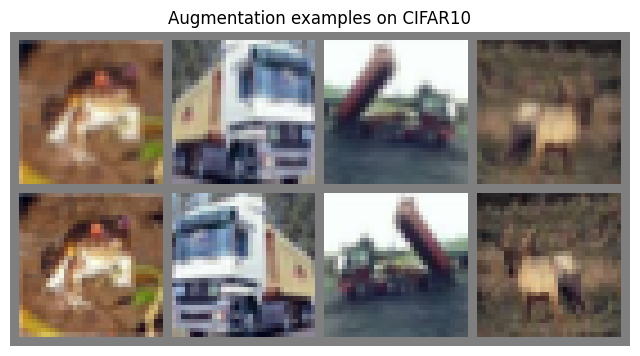

In [19]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

### Constructing a `LightningModule` 

In [20]:
class CIFARModule(L.LightningModule):
    def __init__(self, model, model_hparams, optimizer_hparams):
        super().__init__()
        self.save_hyperparameters()

        num_in_features = resnet_cifar.get_classifier().in_features

        model.fc = nn.Sequential(
            nn.BatchNorm1d(num_in_features),
            nn.Linear(num_in_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 10)
        )

        self.model = model

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True

        self.loss_module = nn.CrossEntropyLoss()
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.fc.parameters(), **self.hparams.optimizer_hparams)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("train_acc", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log("test_acc", acc)


### Training method

This methods includes the training, validation, test logic.

In [21]:
def train_model(model, save_name='resnet', epochs=2, **kwargs):

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        # How many epochs to train for if no patience is set
        max_epochs=epochs,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        lightning_model = CIFARModule.load_from_checkpoint(pretrained_filename)
    else:
        print("No checkpoint found")
        L.seed_everything(42)  # To be reproducible
        lightning_model = CIFARModule(model, **kwargs)
        trainer.fit(lightning_model, train_loader, val_loader)
        lightning_model = CIFARModule.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(lightning_model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(lightning_model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

### Now train

In [22]:
model_hparams = {}
optimizer_hparams = {"lr": 1e-3, "weight_decay": 1e-4}

trained_model, result = train_model(resnet_cifar, model_hparams=model_hparams, optimizer_hparams=optimizer_hparams, epochs=20)

print(f"Final Test Accuracy: {result['test']:.4f}")
print(f"Final Val Accuracy: {result['val']:.4f}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
C:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


No checkpoint found


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode  | In sizes       | Out sizes
--------------------------------------------------------------------------------------
0 | model       | ResNet           | 21.8 M | train | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | train | ?              | ?        
--------------------------------------------------------------------------------------
538 K     Trainable params
21.3 M    Non-trainable params
21.8 M    Total params
87.293    Total estimated model params size (MB)
173       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Final Test Accuracy: 0.4575
Final Val Accuracy: 0.4832


## Plot Accuracy Results

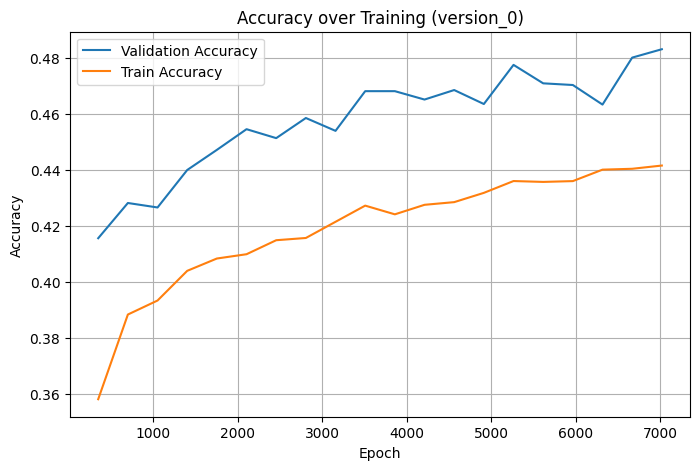

In [23]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import os
import re

# Get the latest version folder inside lightning_logs
base_log_dir = os.path.join(CHECKPOINT_PATH, "resnet", "lightning_logs")
version_dirs = [d for d in os.listdir(base_log_dir) if re.match(r"version_\d+", d)]

if not version_dirs:
    print("No version directories found.")
else:
    # Sort by version number (integer suffix)
    version_dirs.sort(key=lambda x: int(x.split("_")[1]))
    latest_version = version_dirs[-1]
    log_dir = os.path.join(base_log_dir, latest_version)

    # Find the latest event file
    event_file = None
    for file in os.listdir(log_dir):
        if file.startswith("events.out"):
            event_file = os.path.join(log_dir, file)
            break

    if event_file:
        ea = event_accumulator.EventAccumulator(event_file)
        ea.Reload()

        available_tags = ea.Tags()["scalars"]

        def plot_metric(tag, label):
            if tag in available_tags:
                events = ea.Scalars(tag)
                steps = [e.step for e in events]
                values = [e.value for e in events]
                plt.plot(steps, values, label=label)
            else:
                print(f"Skipping {tag}: Not found in logs")

        plt.figure(figsize=(8, 5))
        plot_metric("val_acc", "Validation Accuracy")
        plot_metric("train_acc", "Train Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy over Training ({latest_version})")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No events file found in:", log_dir)

## Classification

In [24]:
from torchvision import transforms
import torch.nn.functional as F

# CIFAR-10 class labels
CIFAR10_LABELS = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Preprocessing: CIFAR-10 style
cifar_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

def classify(image_files):
    # Load model from checkpoint
    ckpt_path = os.path.join(log_dir, "checkpoints", "epoch=1-step=702.ckpt")
    if not os.path.exists(ckpt_path):
        print("Checkpoint not found!")
        return
    
    model = CIFARModule.load_from_checkpoint(ckpt_path)
    model.eval()

    with torch.no_grad():
        print("Classification results:")
        for img_path in image_files:
            try:
                image = Image.open(img_path).convert("RGB")
                input_tensor = cifar_transform(image).unsqueeze(0)
                with torch.no_grad():
                    device = next(model.parameters()).device
                    output = model(input_tensor.to(device))
                    pred_idx = output.argmax(dim=1).item()
                    pred_label = CIFAR10_LABELS[pred_idx]
                    basename = os.path.basename(filename)
                    true_label_i = int(basename.split("_")[2].split(".")[0])
                    true_label = CIFAR10_LABELS[true_label_i]
                    
                    print(f"{basename} {pred_label} {true_label}")
            except Exception as e:
                print(f"Error with {img_path}: {e}")

In [25]:
test_img_dir = "sample_cifar_images"
os.makedirs(test_img_dir, exist_ok=True)

N = 5
image_files = []
print("Saving test images:")
for i in range(N):
    img, label = test_set[i]
    filename = f"{test_img_dir}/img_{i}_{label}.png"
    transforms.ToPILImage()(img).save(filename)
    image_files.append(filename)

# Call your classifier
print("\nRunning classify() on saved images:")
classify(image_files)

Saving test images:

Running classify() on saved images:
Checkpoint not found!


<h2 style="color: blue;">Complete the following tasks</h2>

**1.** Modify the `train_model` function to take the number of epochs as an argument.

**2.** Train the model for at least 20 epochs and plot the validation and test accuracies.

Look at `saved_models/resnet/lightning_logs` for the this information.
   
**3.** Modify the `train_model` function to load the model from *checkpoint*

**4.** Write a function that uses the model trained in step 2 to perform inference in a list of images.  The function prints the list of images alongside their true and predicted labels.  We can use this function as follows:

~~~python
image_files = ["1.png", "2.png"]
classify(image_files)
~~~

The output of this program will look similar to 
~~~text
Classification results:
1.png dog dog
2.png cat dog
~~~
     
**5.** (Bonus) the current classification head consists of single fully-connected layer.  Let's replace it with a neural network with one hidden layer. This can be achieve by replacing the "fc" layer with a *sequence* of layers as seen in the following code snippet.

~~~python
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features=num_in_features, out_features=1024, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.5)
    nn.Linear(in_features=1024, out_features=10, bias=True)
)
~~~

where `num_in_features` simply reflect feature size for the ResNet encoder.  You can find this information as follows

~~~python
num_in_features = resnet_cifar.get_classifier().in_features
~~~



<div style="color: magenta;">
<h2>Jupyter notebook</h2>

Source notebook is available <a href="05a-resnet-lab.ipynb">here</a>.
</div>

## GPU resources

(Experimental) You can use the GPU resources available at [https://hubdev.science.ontariotechu.ca/](https://hubdev.science.ontariotechu.ca/) to complete your lab. 

<center>
    <tr>
    <td><img src="ontario-tech-univ-logo.png" width="25%"></img></td>
    </tr>
</center>